# Hierarchical Redshift Inference from Computed Posteriors

Part 4 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook outlines how to modify the posteriors derived from Part 3 in the context of a **hierarchical model** to better incorporate uncertainties.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

As before, we will use our mock SDSS data to benchmark our tests here.

In [2]:
sdss = pickle.load(open( "mock_sdss_cosmos_bpz.p", "rb" )) # load data
[types, redshifts, mags], templates = sdss.samples, sdss.samples_t # import truth labels

Let's now initialize our catalogs and compute our fits. We use a different selection function this time to broaden our sample.

In [3]:
# dividing into training/testing samples
Nobs = sdss.NSAMPLES
Ntrain, Ntest = 50000, 150000

sel_train = arange(Nobs) # select all available objects
train_sel = sel_train[:Ntrain] # training set

det_lim = 5.
sel_test = arange(Nobs)[(sdss.phot_obs / sdss.noise > det_lim).sum(axis=1) > 0] # S/N > 5 in at least one band
test_sel = sel_test[sel_test>train_sel[-1]][:Ntest] # testing set

Ntrain = len(train_sel)
Ntest = len(test_sel)

print 'Number of observed galaxies (all):', Nobs
print 'Number of training galaxies:', Ntrain
print 'Number of testing galaxies:', Ntest

Number of observed galaxies (all): 500000
Number of training galaxies: 50000
Number of testing galaxies: 150000


In [4]:
# initializing photometry
phot_train, phot_test = sdss.phot_obs[train_sel], sdss.phot_obs[test_sel]
err_train, err_test = sdss.noise[train_sel], sdss.noise[test_sel]

# initializing masks
mask = random.uniform(size=(Ntrain+Ntest, sdss.NFILTER)) > 0.05 # randomly censor 5% of observations
mask[:,2] = True # always detected in r-band (used for selection)
mask_train, mask_test = mask[:Ntrain], mask[Ntrain:Ntrain+Ntest]

csel_train, csel_test = mask_train.sum(axis=1) < sdss.NFILTER, mask_test.sum(axis=1) < sdss.NFILTER

print 'Number of censored training objects:', csel_train.sum()
print 'Number of censored testing objects:', csel_test.sum()

Number of censored training objects: 9202
Number of censored testing objects: 27709


In [5]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
mag, magerr = fz.asinh_mag_map(sdss.phot_obs, sdss.noise, # map f_nu to asinh mag
                               skynoise=sdss.FDEPTHS, zeropoints=flux_zeropoint) # softening parameter and zero-point

# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr) # discretized magnitudes

In [6]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lzidx, lzeidx = rdict.fit(log(1+redshifts), ones(Nobs)*rdict.dlz) # discretized ln(1+z)

In [7]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25)

# initialize WINBET instance (training)
winbet_train = fz.WINBET(Ntrees=25) # 25 trees
winbet_train.train(phot_train, err_train, mask_train)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [8]:
# compute log-likelihoods
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot_train, err_train, mask_train, 
                                                                 phot_test, err_test, mask_test, 
                                                                 impute_train=winbet_train, impute_targ=winbet_train)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 done!


In [9]:
# compute selection probability
model_psel = model_ll.copy()
for i in arange(Ntest):
    if i%5000 == 0: sys.stdout.write(str(i)+' ')
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    
    # training/testing photometry
    ptrain, etrain = phot_train[midx], err_train[midx]
    ptest, etest = phot_test[i], err_test[i]
    
    # computing prob
    mu = ptrain
    x = det_lim * etest
    sigma = sqrt(square(etrain) + square(etest))
    prob = (0.5 * special.erfc((mu-x) / (sqrt(2)*sigma))) # probability of not observing galaxy in each band
    model_psel[i,:Nm] = 1 - prob.prod(axis=1) # complement of not observing galaxy in any bands

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 

In [10]:
# computing evidence
evid_fz = zeros(Ntrain)
for i in arange(Ntest):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model (training object) indices
    ll = model_ll[i,:Nm] # log-likelihoods
    like = exp(-0.5*(ll-ll.min())) # likelihoods
    post = like * model_psel[i,:Nm] # posteriors
    evid_fz[midx] += post/post.sum() # stacked posterior evidence

## Population Inference: Posteriors

In [49]:
Ndraws = 500 # number of samples

Given our posteriors, we can construct population realizations from our data by sampling from the underlying discrete **Poisson process**. In essence, each observed object fundamentally *is* an object from our training set $\mathbf{h}$, just as each $h \in \mathbf{h}$ is actually located at a distinct redshift. In other words, in the limit where $n \rightarrow \infty$, the distribution of objects indistinguishable from $g$ will follow our posterior vector $p_h(g) \equiv P(h|g, s_g=1, \mathcal{S}) \in \mathbf{p}(g)$. However, any *single* object must be sampled from the corresponding multinomial distribution.

Our population distribution can thus be sampled as follows:
1. For $g \in \mathbf{g}$: Draw our posterior samples $\mathbf{p}^{(i)}(g) \sim \mathrm{Mult}[n=1, p=\mathbf{p}(g)]$.
2. Compute our corresponding evidence (i.e. number counts) $\mathbf{Z}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{p}^{(i)}(g)$.

In [105]:
evid_draws = zeros((Ndraws, Ntrain))
for j in xrange(Ndraws):
    sys.stdout.write(str(j)+' ')
    evid_t = zeros(Ntrain)
    for i in arange(Ntest):
        Nm = model_Nobj[i]
        midx = model_obj[i,:Nm]
        ll = model_ll[i,:Nm]
        like = exp(-0.5*(ll-ll.min()))
        post = float64(like * model_psel[i,:Nm])
        evid_draws[j,midx] += multinomial(1, post/post.sum()) # multinomial draw

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Let's check how our realized posterior evidence compares with our original estimates.

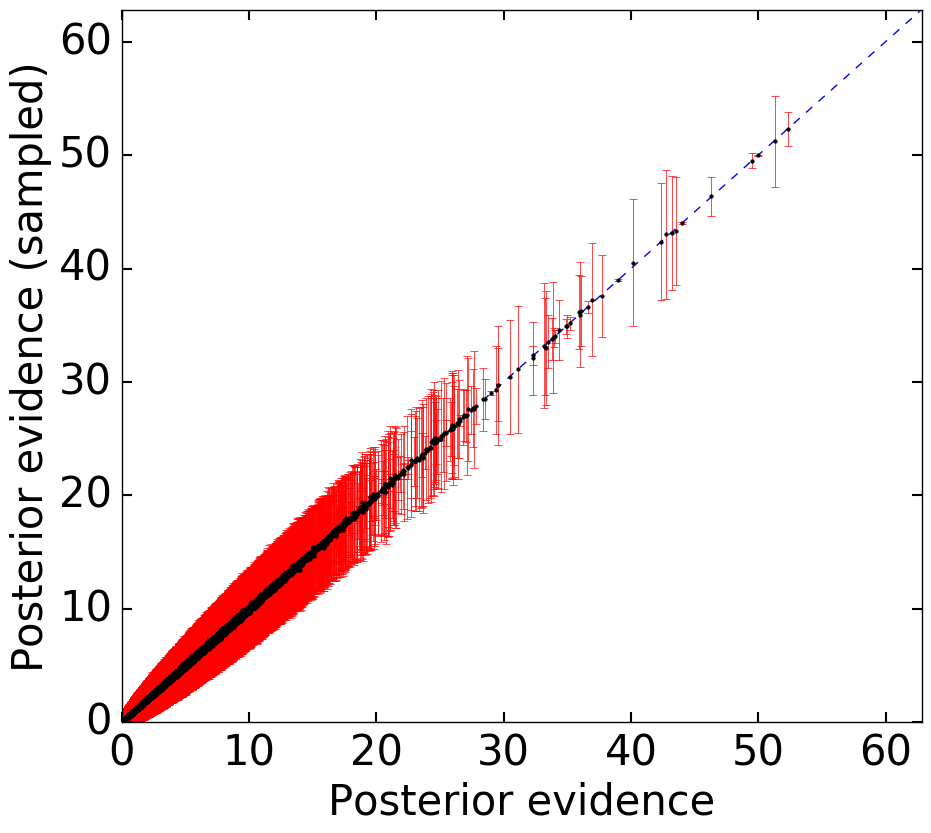

In [107]:
# plotting
figure(figsize=(10,9))
plot([0,1e4], [0,1e4], 'b--', lw=1)
errorbar(evid_fz, evid_draws.mean(axis=0), fmt='k.', yerr=evid_draws.std(axis=0), ecolor='red', markersize=5, lw=0.5)
xlim([0, evid_fz.max()*1.2])
xlabel('Posterior evidence')
ylim([0, evid_fz.max()*1.2])
ylabel('Posterior evidence (sampled)')
tight_layout()

As expected, the two agree!  We can now convert these into population redshift samples to see how variation over our training data translates into variation in our population redshift distribution. Let's first compute our "target" distribution and initial (posterior only) distribution.

In [108]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[test_sel], lzeidx[test_sel], ones(Ntest),
                       rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf /= z_pdf.sum() # normalizing

# compute redshift PDF (initial / likelihood only)
z_pdf_fz = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[train_sel], lzeidx[train_sel], evid_fz,
                           rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf_fz = z_pdf_fz[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf_fz /= z_pdf_fz.sum() # normalizing

As outlined above, individual realizations are discrete entities drawn from the multinomial distribution. In addition, an object's actual redshift within our parameterization (points, bins, etc.) is also a discrete quantity that must be sampled from the corresponding redshift kernel for the particular object. We've initialized our redshift kernels here to have a fixed $1\sigma$ width of $\Delta \ln(1+z) = 0.01$, so this just constitutes adding in some (Poisson) jitter based on this smoothing scale.

In [109]:
lzidx_train, lzeidx_train = lzidx[train_sel], lzeidx[train_sel]

# compute redshift PDFs (train samples)
z_pdf_draws = empty((Ndraws, len(z_pdf)))
for i in xrange(Ndraws):
    if i%10 == 0: sys.stdout.write(str(i)+' ')
    
    # draw discrete objects
    draws = multinomial(Ntest, evid_draws[i]/evid_draws[i].sum())

    # draw discrete redshifts
    zdraws = zeros(rdict.lzgrid_highres.shape)
    for j in arange(Ntrain)[draws>0]:
        tidx, zidx = lzidx_train[j], lzeidx_train[j]
        kernel, width = rdict.sig_dict[zidx], rdict.sig_width[zidx]
        zdraws[tidx-width:tidx+width+1] += multinomial(n=draws[j], pvals=kernel/kernel.sum())
    
    # compute dN/dz
    z_pdf_draws[i] = zdraws[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    z_pdf_draws[i] /= z_pdf_draws[i].sum() # normalizing

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 

In [110]:
# save samples
pop_wt_draws0 = evid_draws.copy()
z_pdf_draws0 = z_pdf_draws.copy()

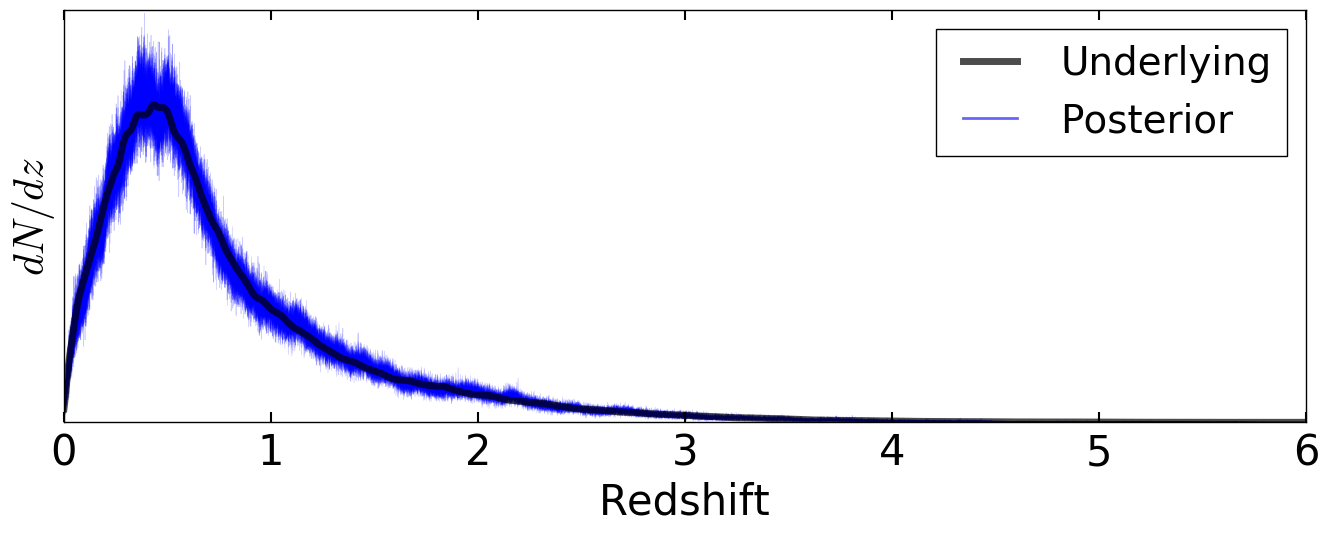

In [114]:
# plot native result
figure(figsize=(14,6))
[plot(rdict.zgrid_highres, z_pdf_draws0[i], lw=0.5, color='blue', alpha=0.2) for i in randint(Ndraws, size=50)]
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black', alpha=0.7, label='Underlying')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='blue', alpha=0.6, label='Posterior')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, z_pdf.max()*1.3])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

While our distributions clearly agree within our samples, the general variation appears quite inordinately large! This is a direct consequence of our Poisson sampling uncertainties: we have ~2.1k individual redshift grid points ($\Delta \ln(1+z) = 10^{-3}$) and 150k objects each with a redshift kernel with a $1\sigma$ width of 10 grid points ($\Delta \ln(1+z) = 10^{-2}$), and so there's a lot of possible ways to downsample the results. While we could used KDE to compute some version of a smoothed distribution, to keep the essence of our Poisson statistics unchanged we'll instead bin our original results to lower resolution.

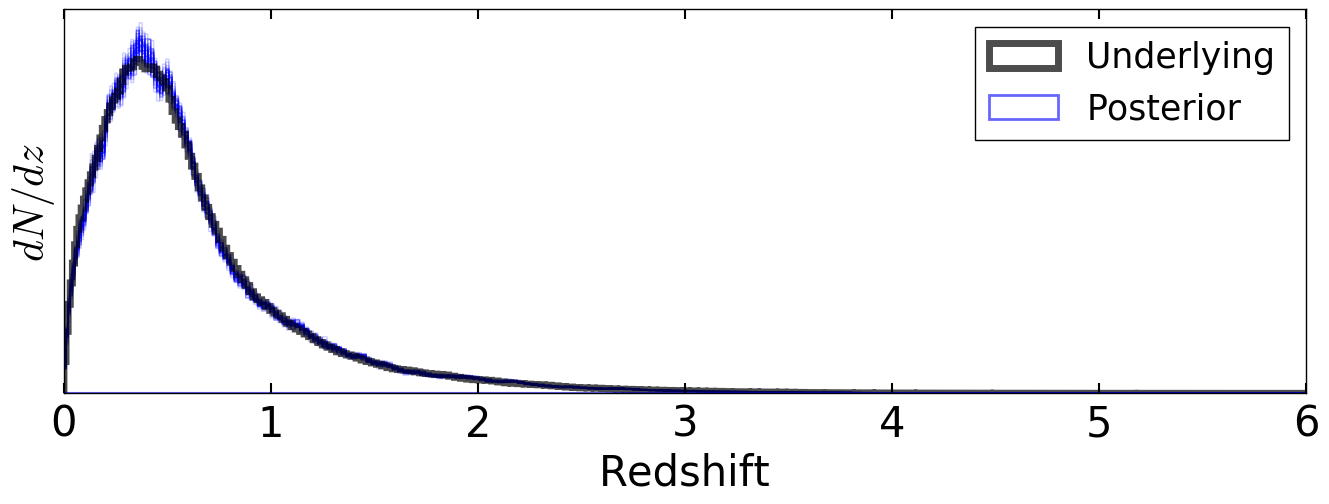

In [116]:
# binned to 10x lower resolution (~210 samples evenly spaced in ln(1+z))
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

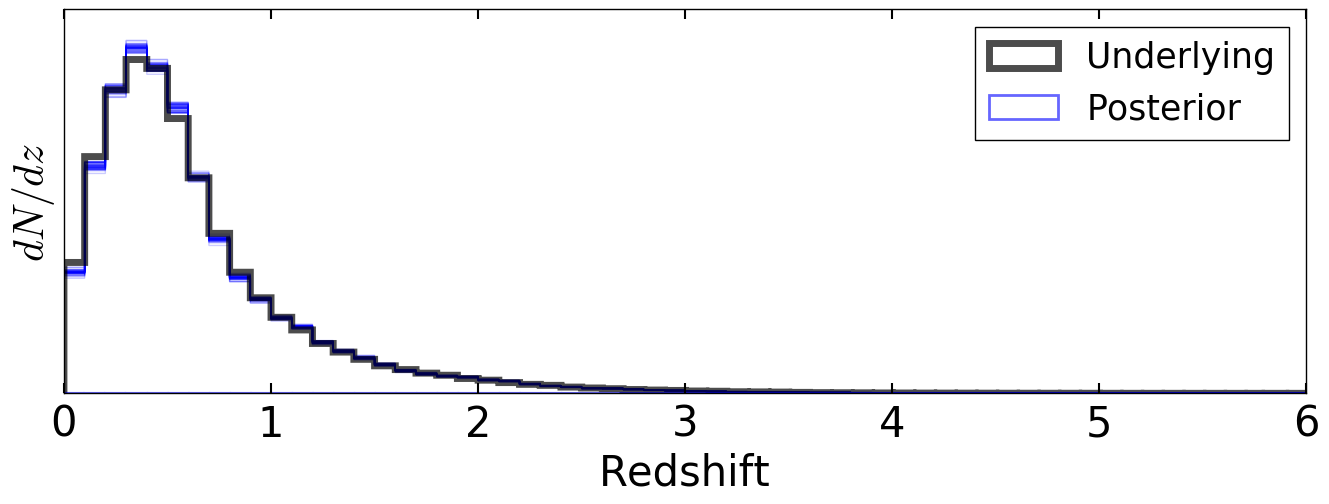

In [117]:
# binned to dz=0.1 resolution (60 samples evenly spaced in z)
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

As we can see, the agreement between the two distributions is not perfect. We will quantify this later in the notebook.

## Population Inference: Weights

As discussed/shown in Leistedt et al. (2016) and Speagle et al. (2017), given a collection of $h \in \mathbf{h}$ objects with corresponding evidences $\mathcal{Z}_h$, the conditional distribution $P(\mathbf{w}|\mathbf{Z})$ for a set of **population weights** $w_h \in \mathbf{w}$ for objects in our training set can be taken to be a **Dirichlet distribution** $\mathrm{Dir}(\mathbf{Z}+1)$ with concentration parameter $\mathcal{Z_h} + 1 \in \mathbf{Z} + 1$ for each $h$. This result arises naturally from our "Big Data" approximation, where we've written our likelihoods in terms of discrete trianing objects instead of continuous distributions. 

Intuitively, this result states that if we picked a new object $g$ at random and knew nothing about it, our "prior" that it could be "sorted" into each of our $h \in \mathbf{h}$ different "categories" follows the **multinomial distribution** with corresponding probabilities $p_h \in \mathbf{p}$ that are proportional to $1+\mathcal{\hat{Z}}_h$, where $\mathcal{\hat{Z}}_h \in \mathbf{\hat{Z}}$ is our "observed" evidence. The Dirichlet then governs the distribution of possible observed $\mathbf{\hat{p}}$ given an underlying $\mathbf{Z}$.

Computing realizations of our population weights conditioned on our posteriors is then relatively straightforward (although somewhat computationally intensive):
1. For $g \in \mathbf{g}$: Draw our posterior samples $\mathbf{p}^{(i)}(g) \sim \mathrm{Mult}[n=1, p=\mathbf{p}(g)]$.
2. Compute our corresponding evidence (i.e. number counts) $\mathbf{Z}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{p}^{(i)}(g)$.
3. Draw our set of population weights $\mathbf{w}^{(i)} \sim P(\mathbf{w} | \mathbf{Z}^{(i)}) \sim \mathrm{Dir}(\mathbf{Z}^{(i)}+1)$.

In [30]:
pop_wt_draws = zeros((Ndraws, Ntrain))
for j in xrange(Ndraws):
    sys.stdout.write(str(j)+' ')
    evid_t = zeros(Ntrain)
    for i in arange(Ntest):
        Nm = model_Nobj[i]
        midx = model_obj[i,:Nm]
        ll = model_ll[i,:Nm]
        like = exp(-0.5*(ll-ll.min()))
        post = float64(like * model_psel[i,:Nm])
        evid_t[midx] += multinomial(1, post/post.sum()) # multinomial draw
    pop_wt_draws[j] = dirichlet(evid_t+1) * Ntest # population weights draw

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

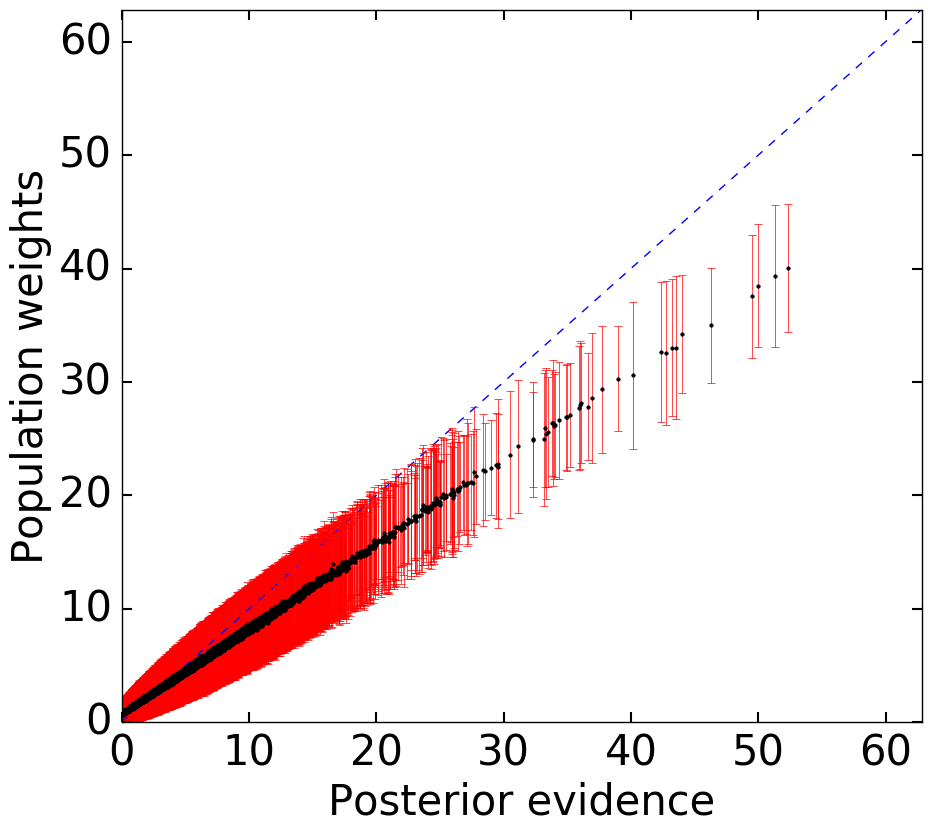

In [41]:
# plotting
figure(figsize=(10,9))
plot([0,1e4], [0,1e4], 'b--', lw=1)
errorbar(evid_fz, pop_wt_draws.mean(axis=0), fmt='k.', yerr=pop_wt_draws.std(axis=0), ecolor='red', markersize=5, lw=0.5)
xlim([0, evid_fz.max()*1.2])
xlabel('Posterior evidence')
ylim([0, evid_fz.max()*1.2])
ylabel('Population weights')
tight_layout()

It is immediately apparent that our posterior evidence does not agree with our population weights. This is a feature of the Dirichlet distribution, which possesses broader tails and a less prominent peak (it "spreads the probability around").

In [33]:
# compute redshift PDFs (train samples)
z_pdf_draws = empty((Ndraws, len(z_pdf)))
for i in xrange(Ndraws):
    if i%10 == 0: sys.stdout.write(str(i)+' ')
    
    # draw discrete objects
    draws = multinomial(Ntest, pop_wt_draws[i]/pop_wt_draws[i].sum())

    # draw discrete redshifts
    zdraws = zeros(rdict.lzgrid_highres.shape)
    for j in arange(Ntrain)[draws>0]:
        tidx, zidx = lzidx_train[j], lzeidx_train[j]
        kernel, width = rdict.sig_dict[zidx], rdict.sig_width[zidx]
        zdraws[tidx-width:tidx+width+1] += multinomial(n=draws[j], pvals=kernel/kernel.sum())
    
    # compute dN/dz
    z_pdf_draws[i] = zdraws[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    z_pdf_draws[i] /= z_pdf_draws[i].sum() # normalizing

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 

In [43]:
# save samples
pop_wt_draws1 = pop_wt_draws.copy()
z_pdf_draws1 = z_pdf_draws.copy()

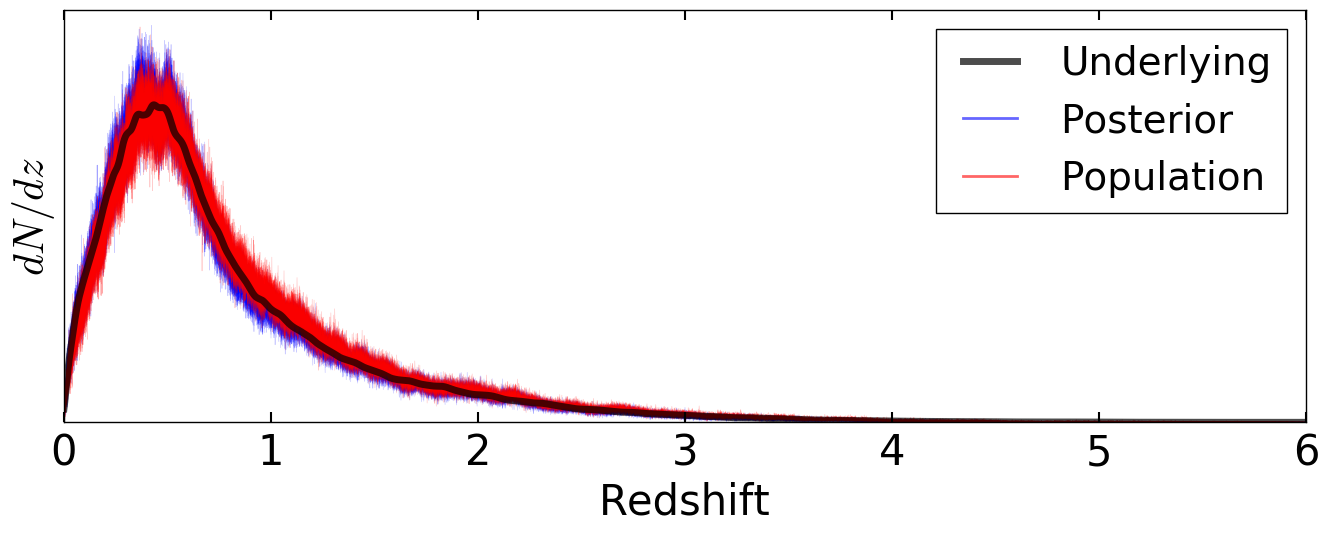

In [119]:
# plot native result
figure(figsize=(14,6))
[plot(rdict.zgrid_highres, z_pdf_draws0[i], lw=0.5, color='blue', alpha=0.2) for i in randint(Ndraws, size=50)]
[plot(rdict.zgrid_highres, z_pdf_draws1[i], lw=0.5, color='red', alpha=0.2) for i in randint(Ndraws, size=50)]
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black', alpha=0.7, label='Underlying')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='blue', alpha=0.6, label='Posterior')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='red', alpha=0.6, label='Population')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, z_pdf.max()*1.3])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

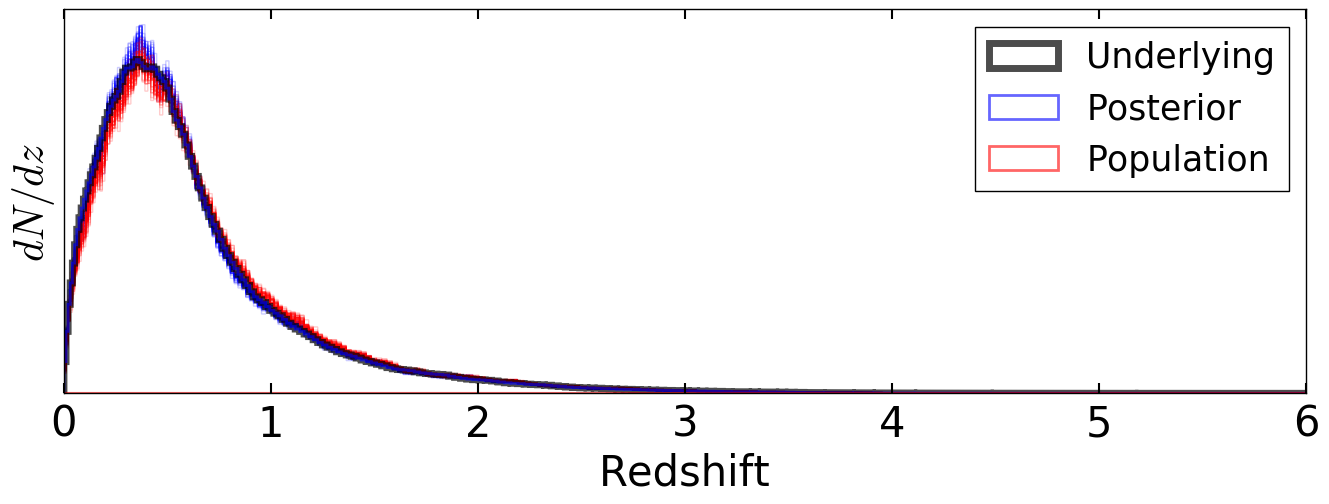

In [120]:
# binned to 10x lower resolution (~210 samples evenly spaced in ln(1+z))
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws1[i], 
      histtype='step', lw=1, color='red', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='red', alpha=0.6, label='Population')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

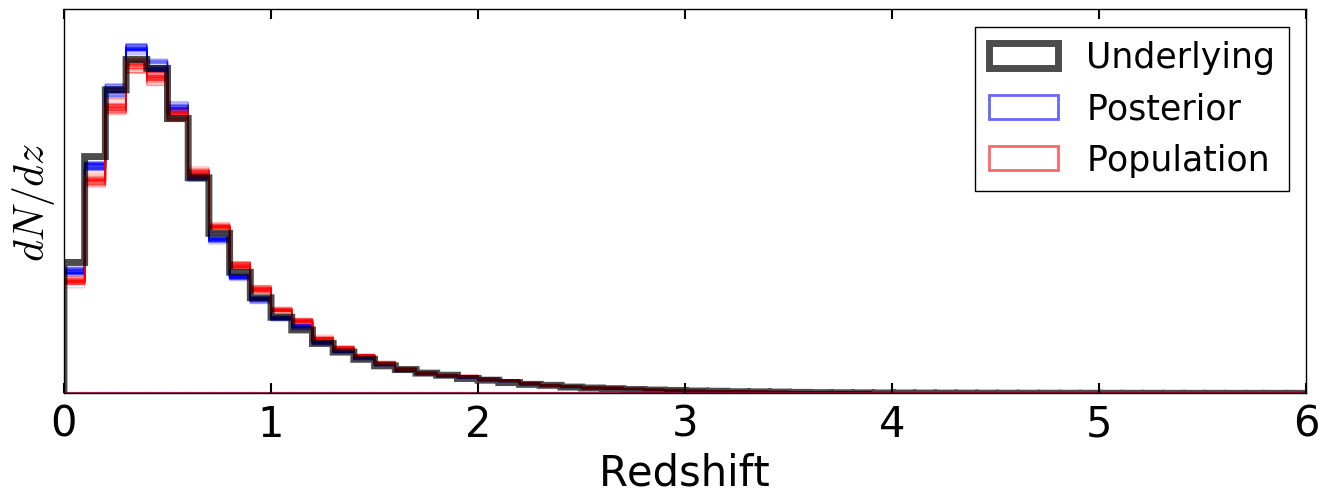

In [121]:
# binned to dz=0.1 resolution (60 samples evenly spaced in z)
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws1[i], 
      histtype='step', lw=1, color='red', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='red', alpha=0.6, label='Population')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

At this resolution, the differences between our "vanilla" posterior results and the population distribution derived from our weights (derived from our posteriors) become more readily apparent.

## Hierarchical Inference

In general, we don't want to assume (as we did above) that we know *a priori* what our posteriors $\lbrace \dots, \mathbf{p}(g) , \dots \rbrace$ are and by extension what $\mathbf{Z}$ is. Instead, we would instead like to sample directly from the **joint distribution** $P(\mathbf{w}, \mathbf{Z})$ via a **hierarchical Bayesian model**. We accomplish this using **Markov Chain Monte Carlo** (MCMC) where the updates to our Markov chains are compute using **Gibbs sampling**. In brief, rather than sampling directly from the joint distribution (which is intractable due to the large number of parameters involved), we instead sample from the respective conditional distributions $P(\mathbf{w}|\mathbf{Z})$ and $P(\mathbf{Z}|\mathbf{w})$ in turn.

Computing realizations of our population weights conditioned on our posteriors is then relatively straightforward (although somewhat computationally intensive):
1. For $g \in \mathbf{g}$: Draw our posterior samples $\mathbf{p}^{(i)}(g) \sim \mathrm{Mult}[n=1, p \propto \mathbf{w}^{(i-1)} \bullet \mathbf{p}(g)]$, where our population weights from the previous Gibbs update now serve as a "prior".
2. Compute our corresponding evidence (i.e. number counts) $\mathbf{Z}^{(i)} = \sum_{g \in \mathbf{g}} \mathbf{p}^{(i)}(g)$.
3. Draw our set of population weights $\mathbf{w}^{(i)} \sim P(\mathbf{w} | \mathbf{Z}^{(i)}) \sim \mathrm{Dir}(\mathbf{Z}^{(i)}+1)$.

We draw samples from our hierarchical model below. Although our chain samples somewhat slowly, we can easily run several in parallel over multiple cores to increase the number of samples. As with most MCMC processes, we also have to "burn in" to the stationary distribution before we can properly utilize our samples.

In [61]:
Nburnin = 200

In [71]:
pop_wt_draws = zeros((Ndraws+Nburnin, Ntrain))
pop_wt_t = evid_fz.copy() # initialize population weights
for j in xrange(Ndraws+Nburnin):
    sys.stdout.write(str(j)+' ')
    evid_t = zeros(Ntrain)
    for i in arange(Ntest):
        Nm = model_Nobj[i]
        midx = model_obj[i,:Nm]
        ll = model_ll[i,:Nm]
        like = exp(-0.5*(ll-ll.min()))
        post = float64(like * model_psel[i,:Nm] * pop_wt_t[midx]) # new posterior realization
        evid_t[midx] += multinomial(1, post/post.sum()) # multinomial draw
    pop_wt_t = dirichlet(evid_t+1) * Ntest # new population weights
    pop_wt_draws[j] = pop_wt_t.copy() # add draw

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Let's examine the autocorrelation of our chain to see how we're doing.

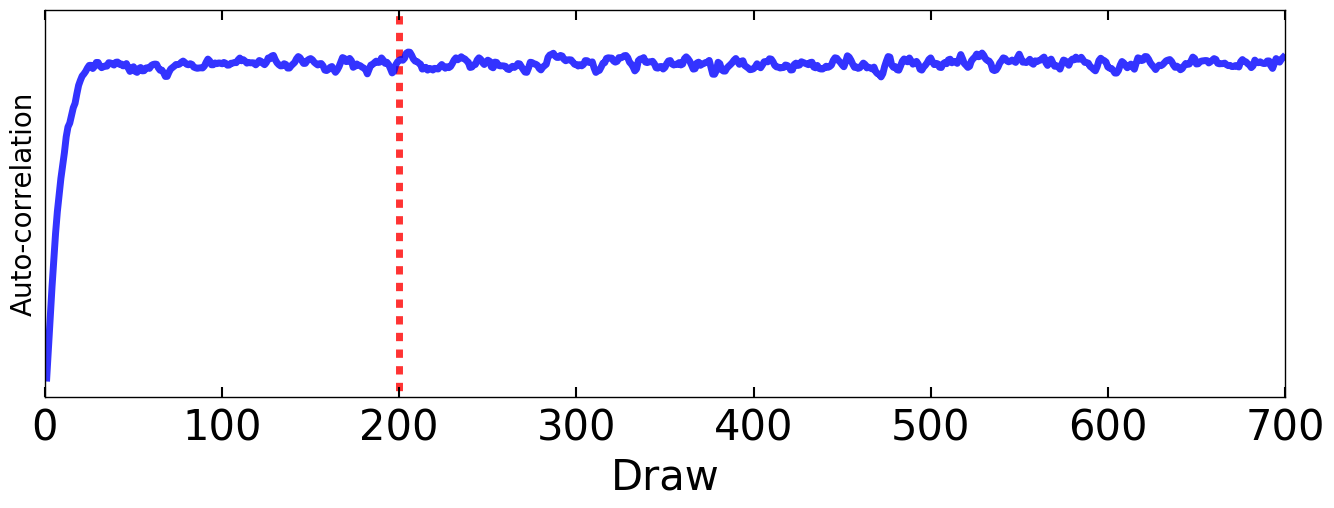

In [83]:
figure(figsize=(16,5))
acorr = array([correlate(pop_wt_draws[i], pop_wt_draws[i+1]) for i in arange(Ndraws+Nburnin-1)]).flatten()
plot(arange(Ndraws+Nburnin-1)+1, acorr, color='blue', lw=5, alpha=0.8)
vlines(Nburnin, 0, 1e10, lw=5, color='red', alpha=0.8, linestyles='--')
xlabel('Draw')
ylim([acorr.min()*0.8, acorr.max()*1.1])
yticks([])
ylabel('Auto-correlation', fontsize=20)

That looks good, so let's burn off our extra samples and see what our final results look like.

In [85]:
pop_wt_draws = pop_wt_draws[Nburnin:]

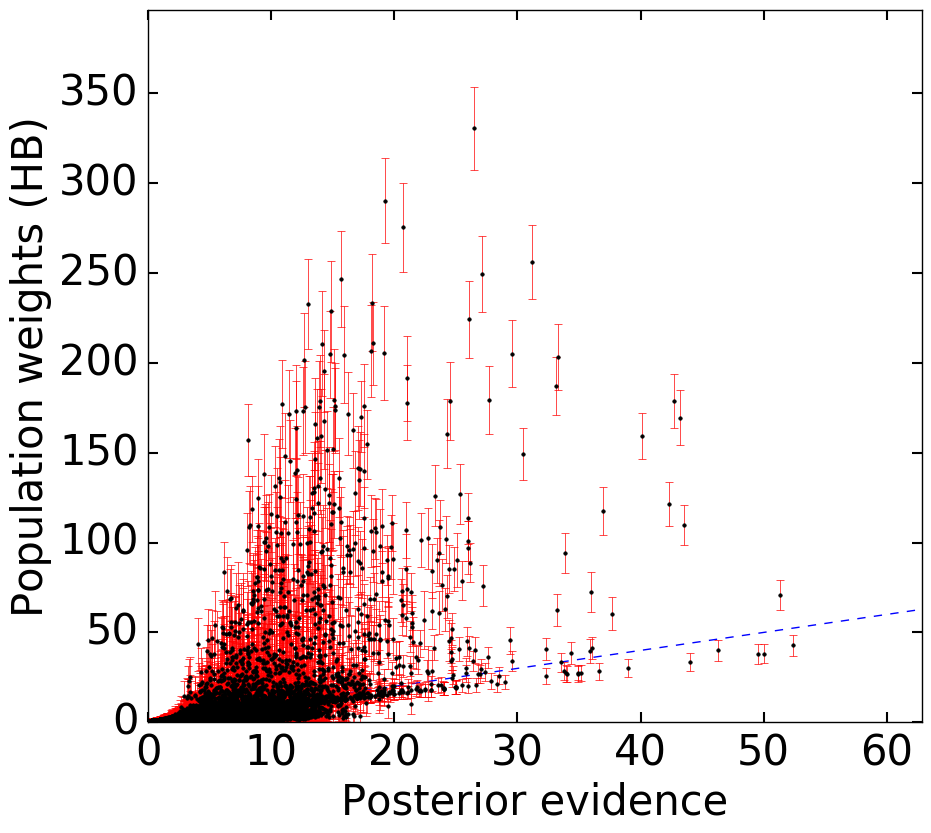

In [90]:
# plotting
figure(figsize=(10,9))
plot([0,1e4], [0,1e4], 'b--', lw=1)
errorbar(evid_fz, pop_wt_draws.mean(axis=0), fmt='k.', yerr=pop_wt_draws.std(axis=0), ecolor='red', markersize=5, lw=0.5)
xlim([0, evid_fz.max()*1.2])
xlabel('Posterior evidence')
ylim([0, pop_wt_draws.mean(axis=0).max()*1.2])
ylabel('Population weights (HB)')
tight_layout()

As expected, our hierarchical model significantly affects the distribution of our population weights compared to our simple conditional case. Let's see how this translates over to our redshift estimates.

In [91]:
# compute redshift PDFs (train samples)
z_pdf_draws = empty((Ndraws, len(z_pdf)))
for i in xrange(Ndraws):
    if i%10 == 0: sys.stdout.write(str(i)+' ')
    
    # draw discrete objects
    draws = multinomial(Ntest, pop_wt_draws[i]/pop_wt_draws[i].sum())

    # draw discrete redshifts
    zdraws = zeros(rdict.lzgrid_highres.shape)
    for j in arange(Ntrain)[draws>0]:
        tidx, zidx = lzidx_train[j], lzeidx_train[j]
        kernel, width = rdict.sig_dict[zidx], rdict.sig_width[zidx]
        zdraws[tidx-width:tidx+width+1] += multinomial(n=draws[j], pvals=kernel/kernel.sum())
    
    # compute dN/dz
    z_pdf_draws[i] = zdraws[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    z_pdf_draws[i] /= z_pdf_draws[i].sum() # normalizing

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 

In [92]:
# save samples
pop_wt_draws2 = pop_wt_draws.copy()
z_pdf_draws2 = z_pdf_draws.copy()

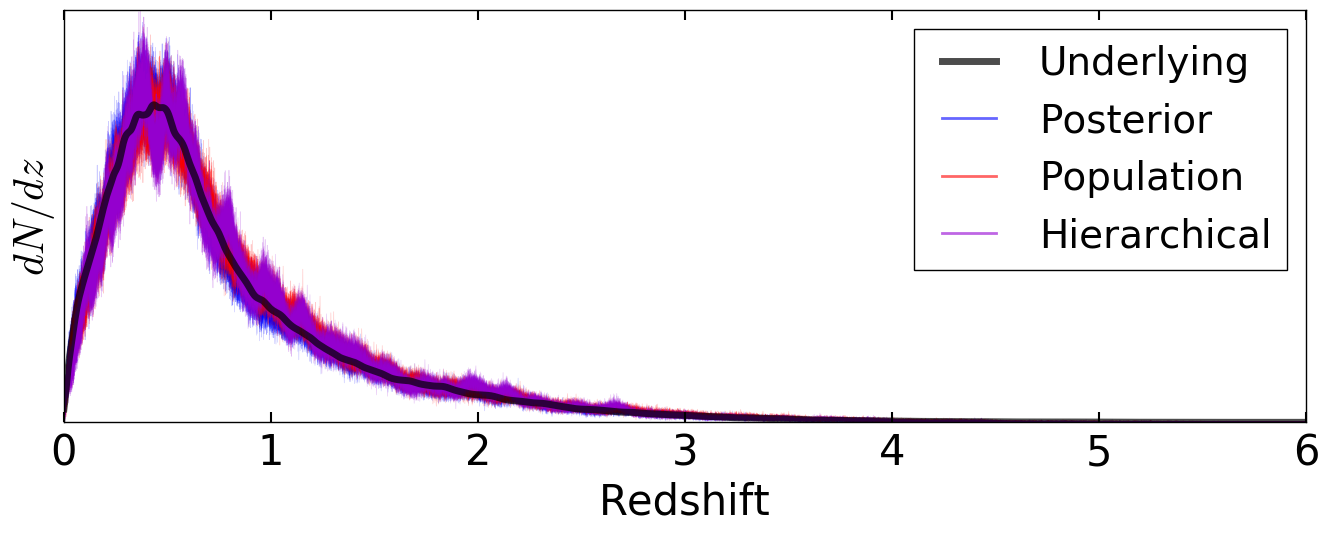

In [122]:
# plot native result
figure(figsize=(14,6))
[plot(rdict.zgrid_highres, z_pdf_draws0[i], lw=0.5, color='blue', alpha=0.2) for i in randint(Ndraws, size=50)]
[plot(rdict.zgrid_highres, z_pdf_draws1[i], lw=0.5, color='red', alpha=0.2) for i in randint(Ndraws, size=50)]
[plot(rdict.zgrid_highres, z_pdf_draws2[i], lw=0.5, color='darkviolet', alpha=0.2) for i in randint(Ndraws, size=50)]
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black', alpha=0.7, label='Underlying')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='blue', alpha=0.6, label='Posterior')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='red', alpha=0.6, label='Population')
plot(rdict.zgrid_highres, z_pdf*0-0.1, lw=2, color='darkviolet', alpha=0.6, label='Hierarchical')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, z_pdf.max()*1.3])
ylabel('$dN/dz$')
legend(fontsize=28, loc='best')
tight_layout()

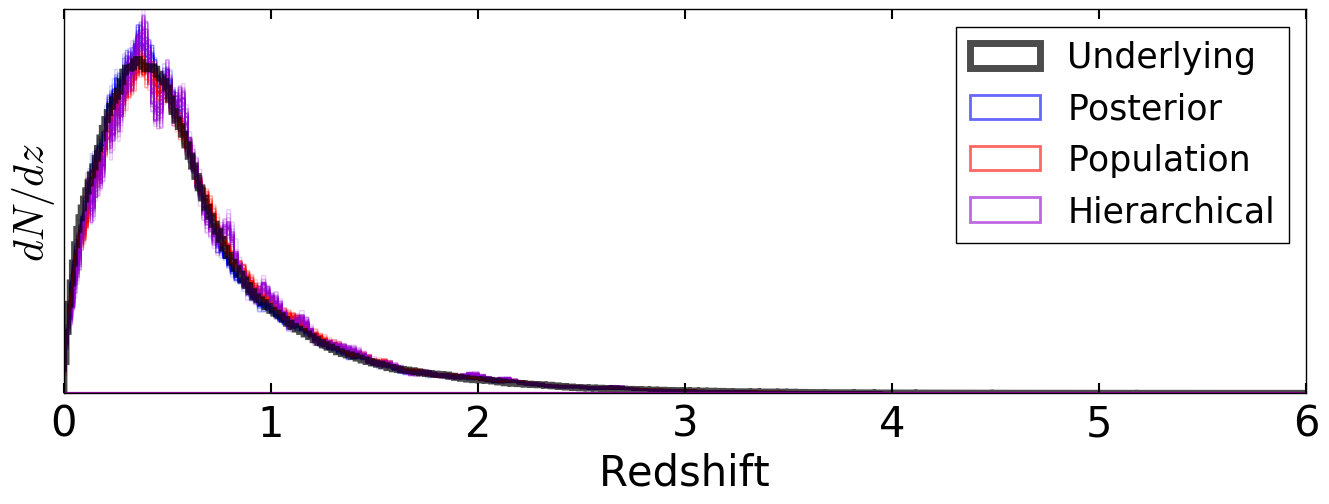

In [123]:
# binned to 10x lower resolution (~210 samples evenly spaced in ln(1+z))
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws1[i], 
      histtype='step', lw=1, color='red', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf_draws2[i], 
      histtype='step', lw=1, color='darkviolet', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='red', alpha=0.6, label='Population')
hist(rdict.zgrid_highres, bins=rdict.zgrid-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='darkviolet', alpha=0.6, label='Hierarchical')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

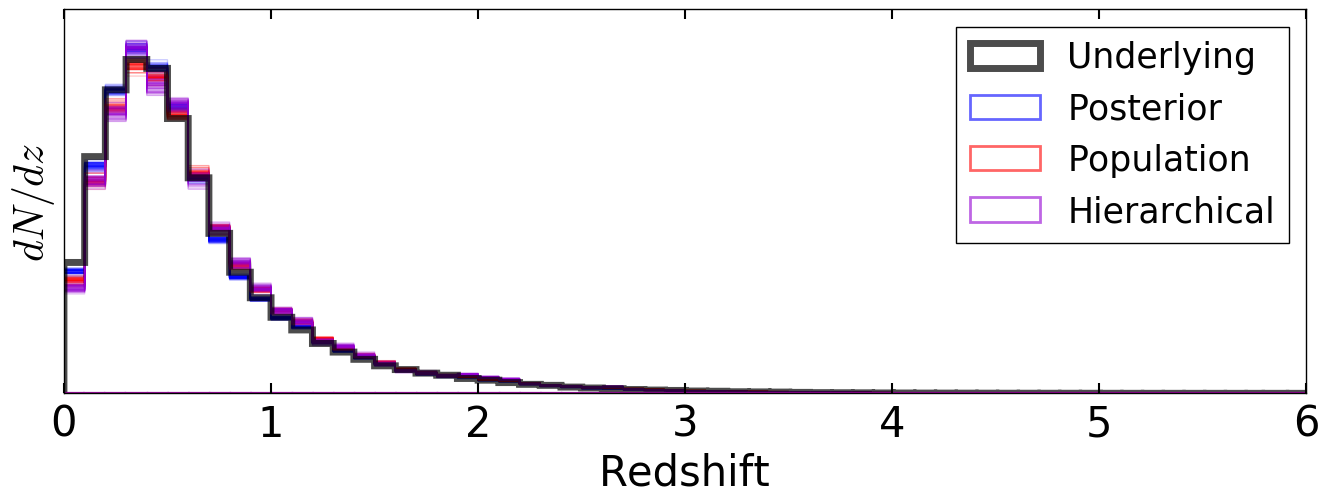

In [124]:
# binned to dz=0.1 resolution (60 samples evenly spaced in z)
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws1[i], 
      histtype='step', lw=1, color='red', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf_draws2[i], 
      histtype='step', lw=1, color='darkviolet', alpha=0.2, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.7, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='red', alpha=0.6, label='Population')
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::10]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='darkviolet', alpha=0.6, label='Hierarchical')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

Now the question is: out of these three models, which gives a more accurate representation of the data?

## Quantifying Performance

Let's now dig a bit deeper into our binned population samples to better quantify how well we're doing. First, let's take a look at the sample covariances. Since the number of free parameters in our covariance/correlation matrix goes as $n(n-1)/2$, our 500 samples will go much further on a $\Delta z = 0.2$ binned distributions (which give $15 \times 29 = 435$ possible free parameters).

In [125]:
# truth
zpdf = histogram(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf, normed=True)[0]
zpdf *= Ntest

# posterior inference
zpdf0 = array([histogram(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws0[i], normed=True)[0] 
               for i in xrange(Ndraws)])
zpdf0 *= Ntest
zpdf0_corr = corrcoef(zpdf0, rowvar=False)
zpdf0_mean = zpdf0.mean(axis=0)

# population inference
zpdf1 = array([histogram(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws1[i], normed=True)[0] 
               for i in xrange(Ndraws)])
zpdf1 *= Ntest
zpdf1_corr = corrcoef(zpdf1, rowvar=False)
zpdf1_mean = zpdf1.mean(axis=0)

# hierarchical inference
zpdf2 = array([histogram(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws2[i], normed=True)[0] 
               for i in xrange(Ndraws)])
zpdf2 *= Ntest
zpdf2_corr = corrcoef(zpdf2, rowvar=False)
zpdf2_mean = zpdf2.mean(axis=0)

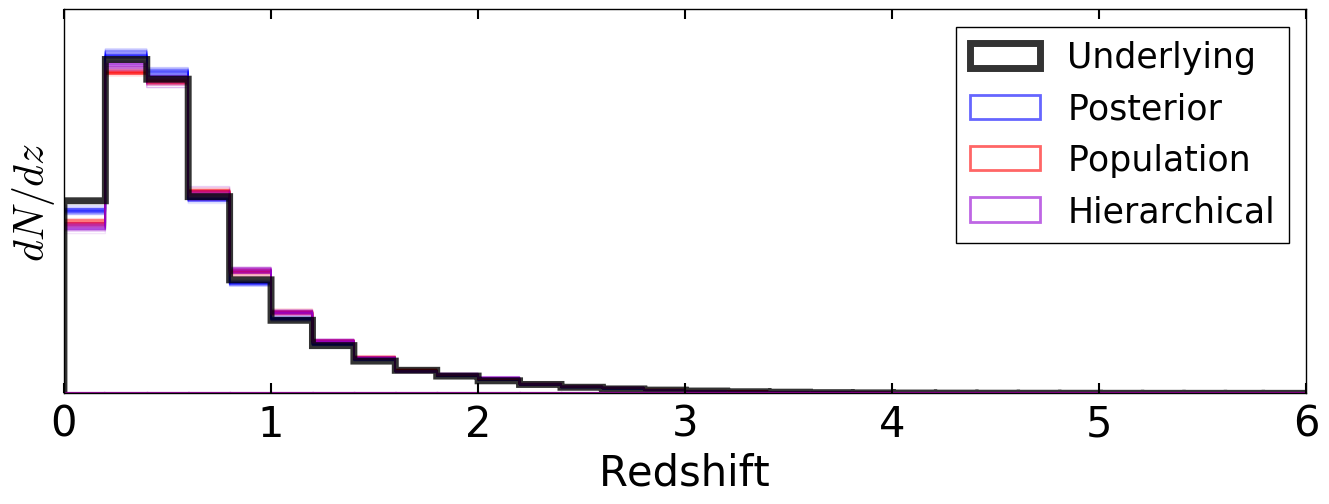

In [126]:
# binned to dz=0.2 resolution (30 samples evenly spaced in z)
figure(figsize=(14,10))
subplot(2,1,1)
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws0[i], 
      histtype='step', lw=1, color='blue', alpha=0.1, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws1[i], 
      histtype='step', lw=1, color='red', alpha=0.1, normed=True) 
 for i in randint(Ndraws, size=50)]
[hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf_draws2[i], 
      histtype='step', lw=1, color='darkviolet', alpha=0.1, normed=True) 
 for i in randint(Ndraws, size=50)]
h = hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf, histtype='step', 
         lw=5, color='black', alpha=0.8, label='Underlying', normed=True)
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='blue', alpha=0.6, label='Posterior')
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='red', alpha=0.6, label='Population')
hist(rdict.zgrid_highres, bins=rdict.zgrid_out[::20]-1e-5, weights=z_pdf*1e-5, histtype='step',
     lw=2, color='darkviolet', alpha=0.6, label='Hierarchical')
xlim([0, 6])
xlabel('Redshift')
yticks([])
ylim([0, h[0].max()*1.15])
ylabel('$dN/dz$')
legend(fontsize=25, loc='best')
tight_layout()

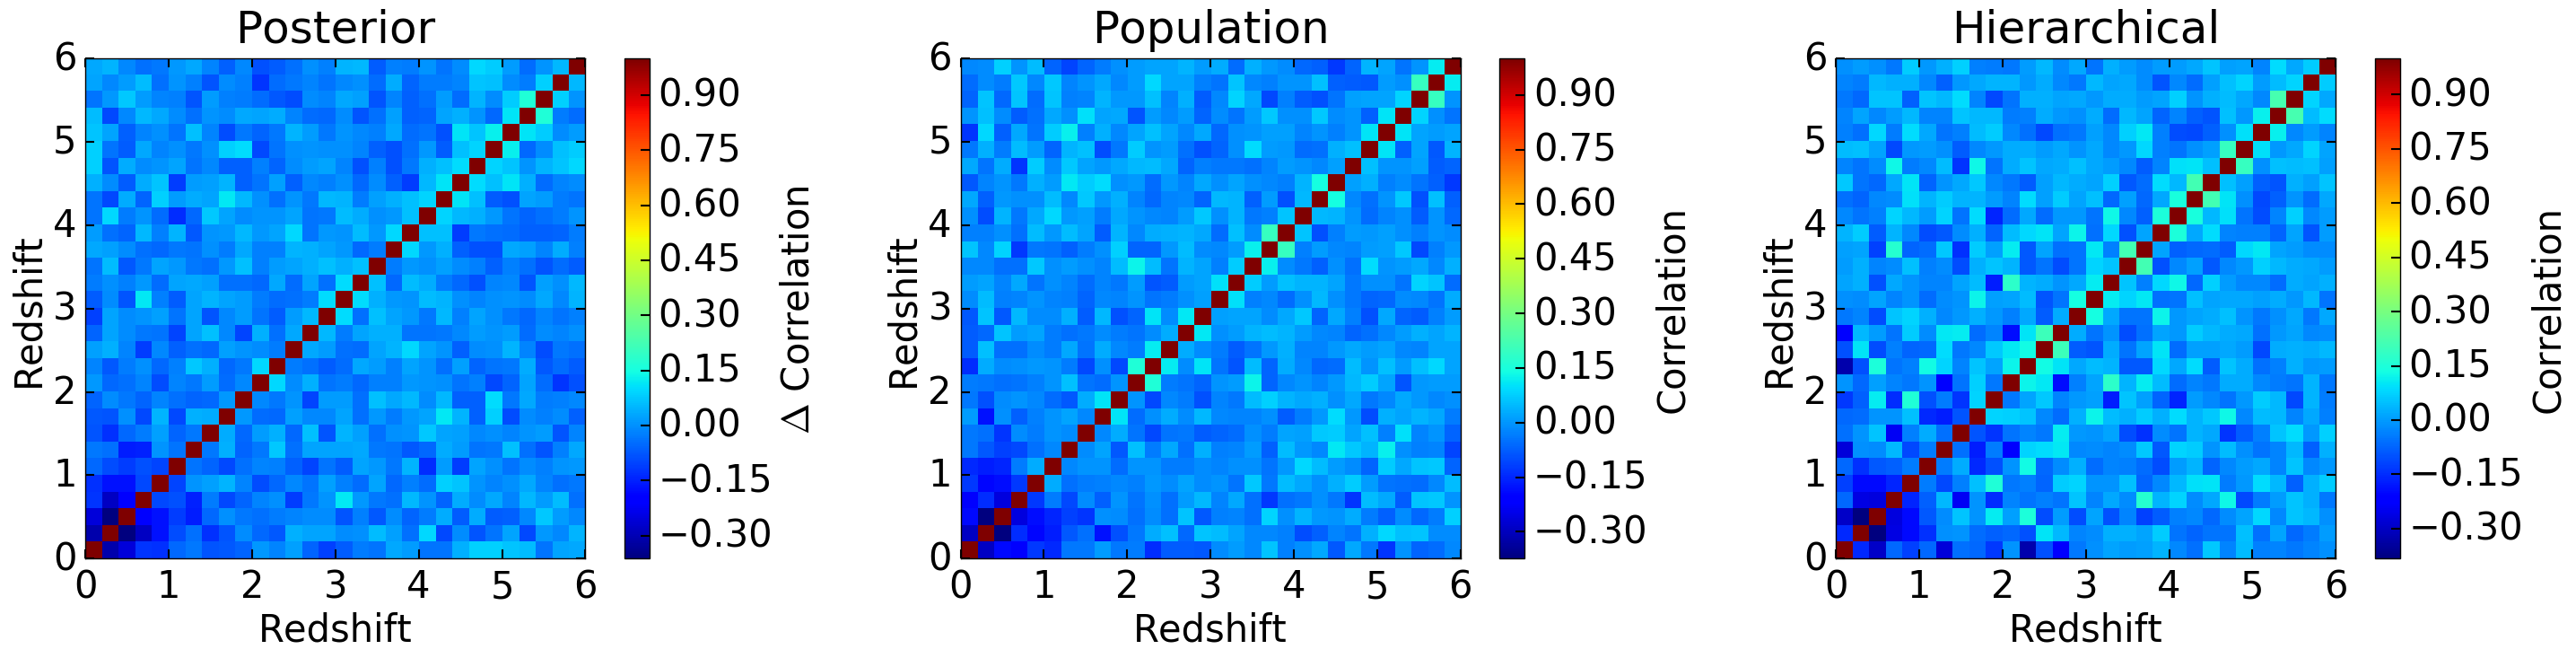

In [127]:
# plot correlation matrices
figure(figsize=(30,8))
subplot(1,3,1)
imshow(zpdf0_corr, origin='lower', cmap='jet', extent=[0,6,0,6], interpolation='nearest')
title('Posterior', y=1.02)
xlabel('Redshift')
ylabel('Redshift')
colorbar(label='$\Delta$ Correlation')
tight_layout()
subplot(1,3,2)
imshow(zpdf1_corr, origin='lower', cmap='jet', extent=[0,6,0,6], interpolation='nearest')
title('Population', y=1.02)
xlabel('Redshift')
ylabel('Redshift')
colorbar(label='Correlation')
tight_layout()
subplot(1,3,3)
imshow(zpdf2_corr, origin='lower', cmap='jet', extent=[0,6,0,6], interpolation='nearest')
title('Hierarchical', y=1.02)
xlabel('Redshift')
ylabel('Redshift')
colorbar(label='Correlation')
tight_layout()

We see a clear progression from our original case to our final case: while our posterior draws do have some inter-bin correlations due to correlated objects, our use of a Dirichlet prior for our population model and our weight-based updates in our hierarchical model progressively increase the correlations between various redshift bins.

Based on our computed sample covariances $\mathbf{\hat{C}}$, we can compute the Mahalanobis norm $||\mathbf{\hat{X}}-\mathbf{X}||_{\mathbf{\hat{C}}^{-1}}$ based on the sample precision matrix $\mathbf{\hat{C}}^{-1}$ where $\mathbf{X}$ is the true underlying $dN/dz$ distribution and $\mathbf{\hat{X}}$ is the mean estimated distribution. 

If our underlying distribution is approximately multivariate Normal, $\mathbf{\hat{C}}$ and $\mathbf{\hat{C}}^{-1}$ can be shown to be sampled from the **Wishart** and **Inverse-Wishart** distributions, respectively. Assuming, however, that our covariance matrices are reasonable estimates of the true covariance matrix $\mathbf{C}$, $||\mathbf{\hat{X}}-\mathbf{X}||_{\mathbf{\hat{C}}^{-1}} \sim \chi^2_p(\delta)$ where $p = 30$ (the number of bins used here). We are thus interested in the PDF of $\delta$ and how consistent our results are with $\delta = 0$.

In [138]:
nc_grid = arange(0, 2000, 0.1)

# base case
delta, sigma = zpdf0_mean-zpdf, diag(zpdf0_mean) # Poisson errors only
prec = inv(sigma)
sqdist = dot(dot(delta, prec), delta.T)
lpnc = array([stats.ncx2.logpdf(sqdist, df=zpdf.shape, nc=nc) for nc in nc_grid]).flatten()
lpnc[0] = stats.chi2.logpdf(sqdist, df=zpdf.shape)
pnc = exp(lpnc)
pnc /= trapz(pnc, nc_grid)

# posterior
delta, sigma = zpdf0_mean-zpdf, cov(zpdf0, rowvar=False)
prec = inv(sigma)
sqdist0 = dot(dot(delta, prec), delta.T)
lpnc0 = array([stats.ncx2.logpdf(sqdist0, df=zpdf.shape, nc=nc) for nc in nc_grid]).flatten()
lpnc0[0] = stats.chi2.logpdf(sqdist0, df=zpdf.shape)
pnc0 = exp(lpnc0)
pnc0 /= trapz(pnc0, nc_grid)

# population inference (w/o hyperprior)
delta, sigma = zpdf1_mean-zpdf, cov(zpdf1, rowvar=False)
prec = inv(sigma)
sqdist1 = dot(dot(delta, prec), delta.T)
lpnc1 = array([stats.ncx2.logpdf(sqdist1, df=zpdf.shape, nc=nc) for nc in nc_grid]).flatten()
lpnc1[0] = stats.chi2.logpdf(sqdist1, df=zpdf.shape)
pnc1 = exp(lpnc1)
pnc1 /= trapz(pnc1, nc_grid)

# population inference (w/ hyperprior)
delta, sigma = zpdf2_mean-zpdf, cov(zpdf2, rowvar=False)
prec = inv(sigma)
sqdist2 = dot(dot(delta, prec), delta.T)
lpnc2 = array([stats.ncx2.logpdf(sqdist2, df=zpdf.shape, nc=nc) for nc in nc_grid]).flatten()
lpnc2[0] = stats.chi2.logpdf(sqdist2, df=zpdf.shape)
pnc2 = exp(lpnc2)
pnc2 /= trapz(pnc2, nc_grid)

Poisson: sqdist =  684.270699558 ; -2lnL = 572.65365657
Posterior: sqdist =  121.684920003 ; -2lnL = 58.4215955146
Population: sqdist =  453.572024129 ; -2lnL = 353.468567802
Hierarchical: sqdist =  297.15178121 ; -2lnL = 208.889833421


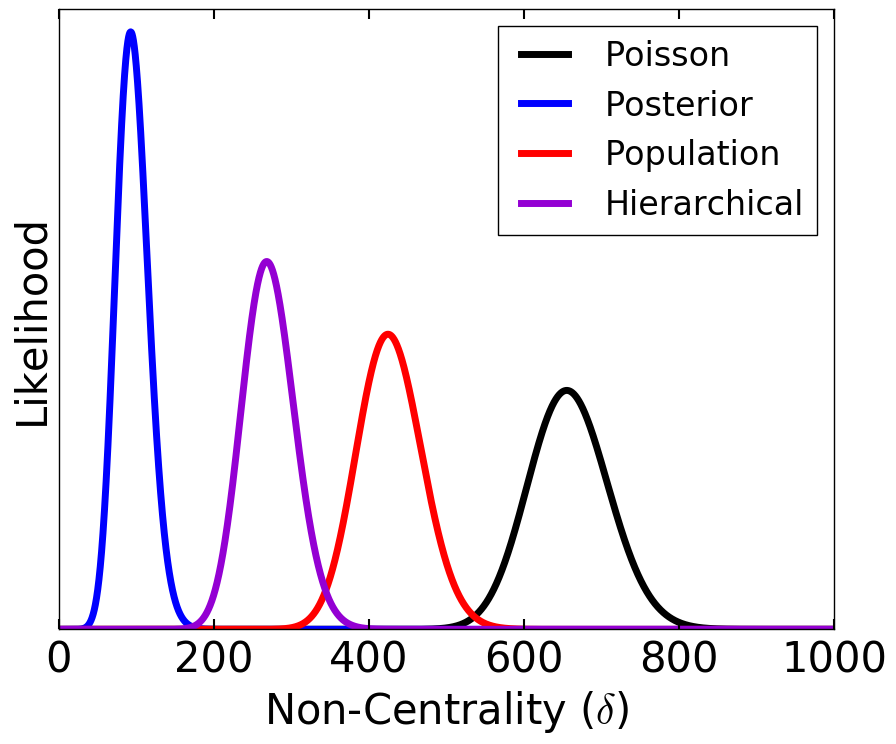

In [139]:
# plotting results
figure(figsize=(10,8))
plot(nc_grid, pnc, color='black', lw=5, label='Poisson')
plot(nc_grid, pnc0, color='blue', lw=5, label='Posterior')
plot(nc_grid, pnc1, color='red', lw=5, label='Population')
plot(nc_grid, pnc2, color='darkviolet', lw=5, label='Hierarchical')
xlim([0, 1000])
yticks([])
legend(fontsize=24, loc='best')
xlabel('Non-Centrality ($\delta$)')
ylabel('Likelihood')
print 'Poisson: sqdist = ', sqdist, '; -2lnL =', -2*log(pnc[0])
print 'Posterior: sqdist = ', sqdist0, '; -2lnL =', -2*log(pnc0[0])
print 'Population: sqdist = ', sqdist1, '; -2lnL =', -2*log(pnc1[0])
print 'Hierarchical: sqdist = ', sqdist2, '; -2lnL =', -2*log(pnc2[0])

It's markedly apparent that just using a (diagonal) Poisson approximation significantly underestimates the true extent of our errors, which are better captured by sampling the posteriors explicitly for each sample. In other words, the samples from the sum does not have the same distribution as the sum of the samples.

Our Dirichlet-based population model doesn't do too well. While our Dirichlet does increase the covariances among neighboring redshift bins, the overall systematic bias induced by our model overwhelms these larger error bars.

Finally, our hierarchical model goes some way towards recovering the original distribution by further increasing the covariance among redshift bins due to our joint modeling of the subsequent posteriors.

## Individual Objects

Coming soon...